In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../..")

In [3]:
import numpy as np

In [4]:
from librep.datasets.har.loaders import MotionSense_BalancedView20HZ

2022-11-08 01:53:07.584022: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-08 01:53:07.584042: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
from librep.transforms.topo_ae import (
    TopologicalDimensionalityReduction,
    CustomTopoDimRedTransform
)
from librep.metrics.dimred_evaluator import DimensionalityReductionQualityReport
from Experiments_topoae_KuHar20Hz_helper import *

In [6]:
# MotionSense Loader
loader = MotionSense_BalancedView20HZ(
    root_dir="../../../data/views/MotionSense/balanced_view_20Hz_with_gravity_9.81_acc_standard", 
    download=False
)

# Print the readme (optional)
loader.print_readme()
# kuhar_data = obtainKuHar20Hz()
# train_HD = kuhar_data['train_HD']
# train_LD = kuhar_data['train_LD']
# train_Y = kuhar_data['train_Y']
# test_HD = kuhar_data['test_HD']
# test_LD = kuhar_data['test_LD']
# test_Y = kuhar_data['test_Y']

# Balanced MotionSense View Resampled to 20Hz with Gravity - Multiplied acc by 9.81m/s²

This is a view from [MotionSense] that was spllited into 3s windows and was resampled to 20Hz using the [FFT method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample). 

The data was first splitted in three sets: train, validation and test. Each one with the following proportions:
- Train: 70% of samples
- Validation: 10% of samples
- Test: 20% of samples

After splits, the datasets were balanced in relation to the activity code column, that is, each subset have the same number of activitiy samples.

**NOTE**: Each subset contain samples from distinct users, that is, samples of one user belongs exclusivelly to one of three subsets.

## Activity codes
- 0: downstairs (569 train, 101 validation, 170 test) 
- 1: upstairs (569 train, 101 validation, 170 test) 
- 2: sitting (569 train, 101 validation, 170 test) 
- 3: standing (569 train, 101 validation, 170 test) 
- 4: walking (569 train, 101 validation, 170 test) 
- 5: jogging (569 train, 101 validation, 170 test) 
 

## Standartized activity codes
- 0: sit (569 train, 101 validation, 170 test) 
- 1: stand (569 train, 101 validation, 170 test) 
- 2: walk (569 train, 101 validation, 170 test) 
- 3: stair up (569 train, 101 validation, 170 test) 
- 4: stair down (569 train, 101 validation, 170 test) 
- 5: run (569 train, 101 validation, 170 test) 
      




In [7]:
# Load the dataset
# If concat_train_validation is true, return a tuple (train+validation, test)
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=4020, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=1020, features=360, no. window=6, label_columns='standard activity code')

In [8]:
train_HD = np.array(train_val[:][0])
train_Y = np.array(train_val[:][1])
test_HD = np.array(test[:][0])
test_Y = np.array(test[:][1])

# Visualization helper

In [9]:
def visualize(X, Y, filtered=None, xlim=None, ylim=None):
    data_grouped = list(zip(X, Y))
    uniques = filtered
    if filtered is None:
        uniques = np.unique(Y)
    
    for uval in uniques:
        data = [pair[0] for pair in data_grouped if pair[1]==uval]
        data_x = [unit[0] for unit in data]
        data_y = [unit[1] for unit in data]
        plt.scatter(data_x, data_y, label = uval)
    # print(data)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.grid()
    plt.legend()
    plt.show()

# Applying Scaler

MinMaxScaler, MaxAbsScaler and StandardScaler apply the scaling PER FEATURE, which means the distance between points would actually be modified, and so, the ranking as well.
Because of this, a new Scaler is used

In [10]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [11]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.fftpack

# # Number of samplepoints
# N = 600
# # sample spacing
# T = 1.0 / 800.0
# x = np.linspace(0.0, N*T, N)
# y = 2*(np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x))
# yf = scipy.fftpack.fft(y)
# xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


# # print(x)
# # print(xf)

# fig, ax = plt.subplots()
# # ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# ax.plot(x,y)
# plt.show()

# fig, ax = plt.subplots()
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# # ax.plot(x,y)
# plt.show()


In [12]:
# from sklearn import preprocessing

# scaler = preprocessing.MinMaxScaler()

In [13]:
# train_HD = scaler.fit_transform(train_dataset_fft.X)
# train_LD = None
# # train_Y = train_dataset_fft.y
# test_HD = scaler.fit_transform(test_dataset_fft.X)
# test_LD = None
# # test_Y = test_dataset_fft.y

## Set Reporter

In [14]:
reporter = ClassificationReport(
    use_accuracy=True, 
    use_f1_score=True,
    use_classification_report=False,
    use_confusion_matrix=False,
    plot_confusion_matrix=False
)

# **SECTION:** Exploring Topological AE (dimensions)

In [15]:
dimensions_to_explore = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 50, 100]
# dimensions_to_explore = [2, 5]
executions_per_model = 5
# executions_per_model = 1


def explore_dimension(train_HD, train_Y, test_HD, test_Y,
                      topoae_dimension, times_to_execute=10):
    topoae_lambda = 5
    result_object = {
        'RF-ACC': [],
        'RF-F1': [],
        'SVC-ACC': [],
        'SVC-F1': [],
        'KNN-ACC': [],
        'KNN-F1': [],
        'Trustworthiness': [],
        'Continuity': [],
        'Co-k-NNs': []
    }
    for _ in range(times_to_execute):
        # model_lam = 1
        # model_dim = 10
        model_epc = 125
        topo_reducer = CustomTopoDimRedTransform(
            model_name='DeepAE_custom_dim',
            model_lambda=topoae_lambda,
            patience=None,
            num_epochs=model_epc,
            from_dim=360,
            to_dim=topoae_dimension
        )
        title_plot = "MotionSense 20Hz\nTopoAE lambda " + str(topoae_lambda)
        topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)
        train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, topoae_dimension))
        test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, topoae_dimension))
        experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
        metrics_reporter = DimensionalityReductionQualityReport()
        metrics_report = metrics_reporter.evaluate([test_HD, test_LD])
        
        result_object['RF-ACC'].append(experiments_result['RF-ACC'])
        result_object['RF-F1'].append(experiments_result['RF-F1'])
        result_object['SVC-ACC'].append(experiments_result['SVC-ACC'])
        result_object['SVC-F1'].append(experiments_result['SVC-F1'])
        result_object['KNN-ACC'].append(experiments_result['KNN-ACC'])
        result_object['KNN-F1'].append(experiments_result['KNN-F1'])
        
        result_object['Trustworthiness'].append(metrics_report['trustworthiness'])
        result_object['Continuity'].append(metrics_report['continuity'])
        result_object['Co-k-NNs'].append(metrics_report['co k nearest neighbor size'])
        
    # for obj_property in result_object:
    #     mean_val = np.mean(result_object[obj_property])
    #     min_val = np.min(result_object[obj_property])
    #     max_val = np.max(result_object[obj_property])
    #     result_object[obj_property] = (min_val, mean_val, max_val)

    return result_object


Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 2
Epoch:1, P:None, Loss:23.1614, Loss-ae:23.0355, Loss-topo:0.0252
Epoch:2, P:None, Loss:23.0531, Loss-ae:22.9897, Loss-topo:0.0127
Epoch:3, P:None, Loss:23.2041, Loss-ae:23.1557, Loss-topo:0.0097
Epoch:4, P:None, Loss:22.8553, Loss-ae:22.7956, Loss-topo:0.0119
Epoch:5, P:None, Loss:23.7471, Loss-ae:23.6991, Loss-topo:0.0096
Epoch:6, P:None, Loss:23.5328, Loss-ae:23.3110, Loss-topo:0.0444
Epoch:7, P:None, Loss:22.9793, Loss-ae:22.8726, Loss-topo:0.0213
Epoch:8, P:None, Loss:22.4752, Loss-ae:22.4300, Loss-topo:0.0091
Epoch:9, P:None, Loss:22.5747, Loss-ae:22.5285, Loss-topo:0.0092
Epoch:10, P:None, Loss:22.5745, Loss-ae:22.4454, Loss-topo:0.0258
Epoch:11, P:None, Loss:23.5952, Loss-ae:23.5800, Loss-topo:0.0030
Epoch:12, P:None, Loss:23.1130, Loss-ae:23.0823, Loss-topo:0.0061
Epoch:13, P:None, Loss:22.8652, Loss-ae:22.8332, Loss-topo:0.0064
Epoch:14, P:None, Loss:2

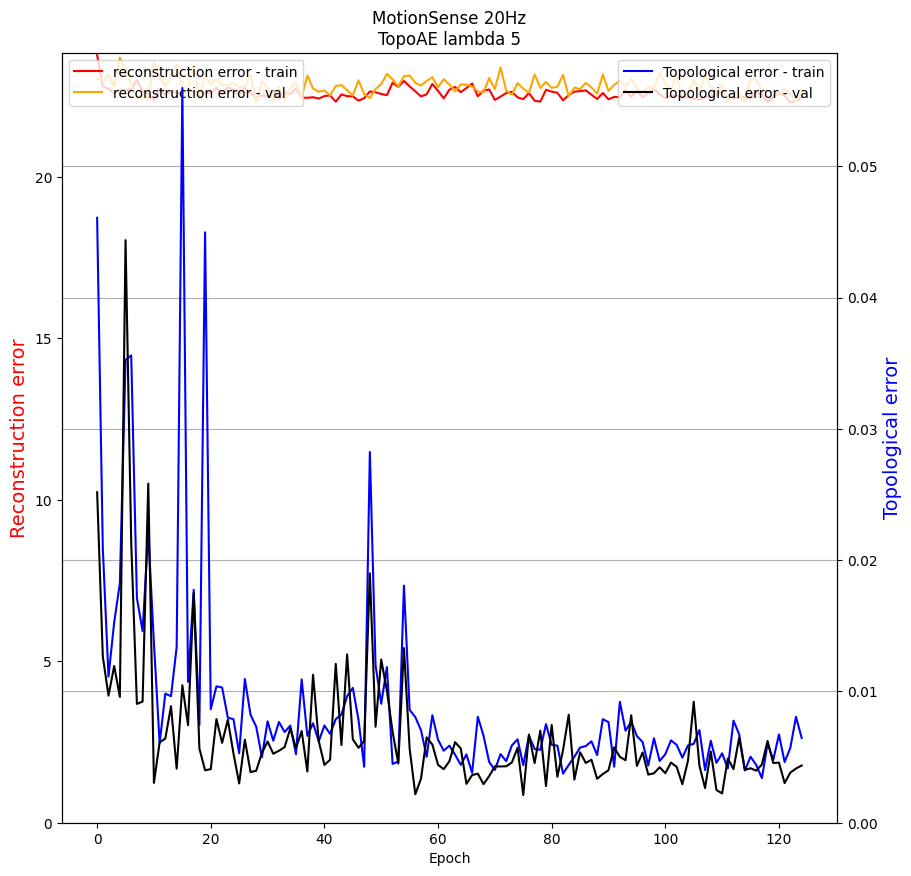

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 2
Epoch:1, P:None, Loss:23.3085, Loss-ae:23.2280, Loss-topo:0.0161
Epoch:2, P:None, Loss:23.5210, Loss-ae:23.4666, Loss-topo:0.0109
Epoch:3, P:None, Loss:22.9551, Loss-ae:22.8647, Loss-topo:0.0181
Epoch:4, P:None, Loss:23.5041, Loss-ae:23.4749, Loss-topo:0.0058
Epoch:5, P:None, Loss:23.0489, Loss-ae:22.9968, Loss-topo:0.0104
Epoch:6, P:None, Loss:22.8314, Loss-ae:22.7820, Loss-topo:0.0099
Epoch:7, P:None, Loss:22.9118, Loss-ae:22.8851, Loss-topo:0.0053
Epoch:8, P:None, Loss:23.6769, Loss-ae:23.4069, Loss-topo:0.0540
Epoch:9, P:None, Loss:23.1804, Loss-ae:23.1251, Loss-topo:0.0111
Epoch:10, P:None, Loss:22.9997, Loss-ae:22.9618, Loss-topo:0.0076
Epoch:11, P:None, Loss:23.2574, Loss-ae:23.1998, Loss-topo:0.0115
Epoch:12, P:None, Loss:22.9717, Loss-ae:22.9456, Loss-topo:0.0052
Epoch:13, P:None, Loss:22.9613, Loss-ae:22.9218, Loss-topo:0.0079
Epoch:14, P:None, Loss:2

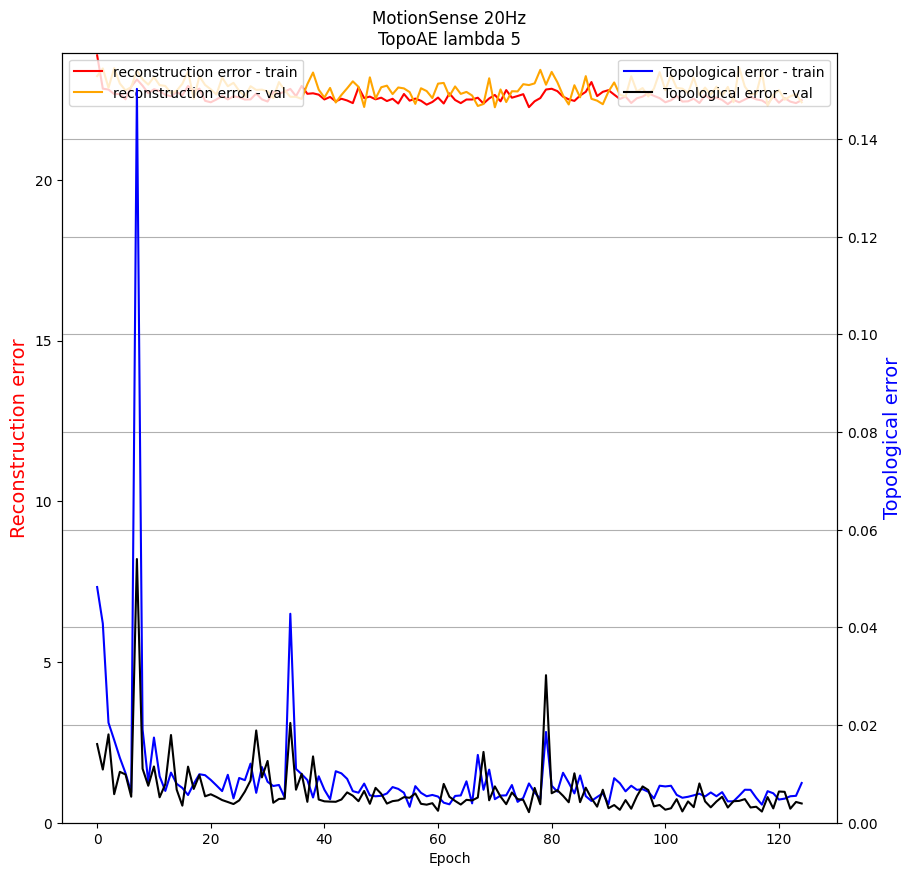

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 2
Epoch:1, P:None, Loss:23.4710, Loss-ae:23.3512, Loss-topo:0.0240
Epoch:2, P:None, Loss:23.0277, Loss-ae:22.9545, Loss-topo:0.0146
Epoch:3, P:None, Loss:23.0186, Loss-ae:22.9922, Loss-topo:0.0053
Epoch:4, P:None, Loss:22.8679, Loss-ae:22.7669, Loss-topo:0.0202
Epoch:5, P:None, Loss:23.4027, Loss-ae:23.3875, Loss-topo:0.0030
Epoch:6, P:None, Loss:23.2713, Loss-ae:23.2446, Loss-topo:0.0053
Epoch:7, P:None, Loss:22.9960, Loss-ae:22.9337, Loss-topo:0.0125
Epoch:8, P:None, Loss:23.0055, Loss-ae:22.9792, Loss-topo:0.0053
Epoch:9, P:None, Loss:22.4951, Loss-ae:22.4773, Loss-topo:0.0036
Epoch:10, P:None, Loss:22.6678, Loss-ae:22.6038, Loss-topo:0.0128
Epoch:11, P:None, Loss:23.1757, Loss-ae:23.1457, Loss-topo:0.0060
Epoch:12, P:None, Loss:22.6966, Loss-ae:22.6782, Loss-topo:0.0037
Epoch:13, P:None, Loss:22.6022, Loss-ae:22.5670, Loss-topo:0.0070
Epoch:14, P:None, Loss:2

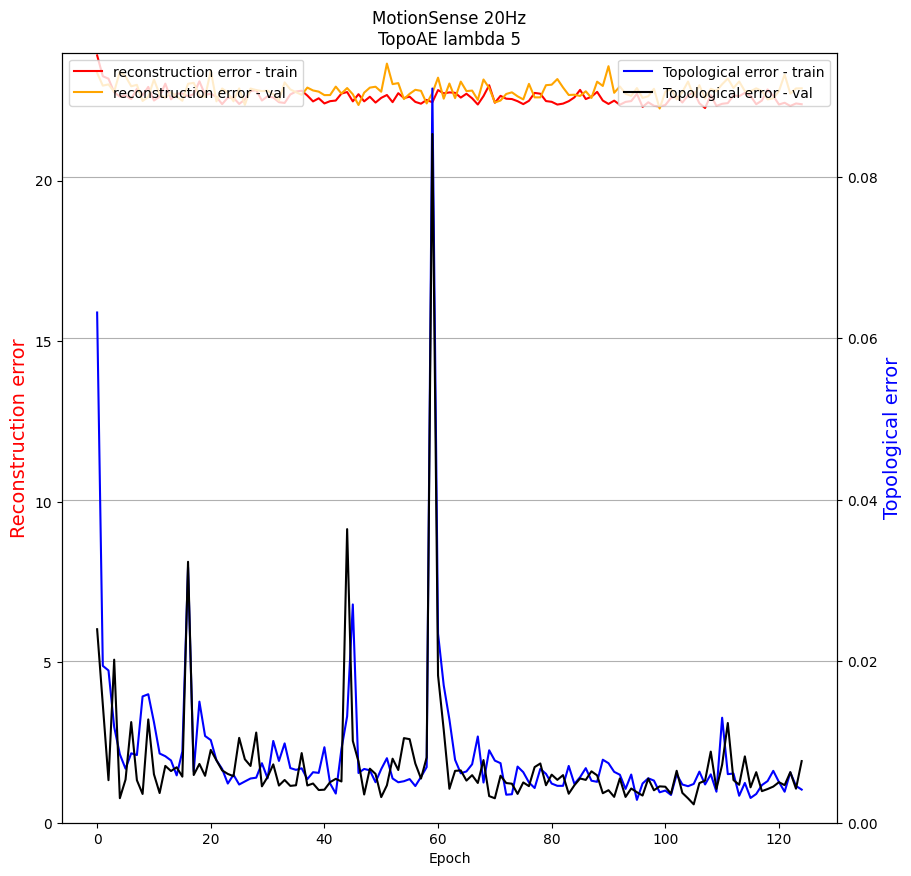

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 2
Epoch:1, P:None, Loss:23.7867, Loss-ae:23.1905, Loss-topo:0.1192
Epoch:2, P:None, Loss:22.7236, Loss-ae:22.6438, Loss-topo:0.0159
Epoch:3, P:None, Loss:22.6323, Loss-ae:22.5193, Loss-topo:0.0226
Epoch:4, P:None, Loss:23.3948, Loss-ae:23.3641, Loss-topo:0.0061
Epoch:5, P:None, Loss:23.5608, Loss-ae:23.5184, Loss-topo:0.0085
Epoch:6, P:None, Loss:23.2707, Loss-ae:23.2335, Loss-topo:0.0074
Epoch:7, P:None, Loss:23.2846, Loss-ae:22.9536, Loss-topo:0.0662
Epoch:8, P:None, Loss:23.0998, Loss-ae:23.0508, Loss-topo:0.0098
Epoch:9, P:None, Loss:23.1925, Loss-ae:23.1545, Loss-topo:0.0076
Epoch:10, P:None, Loss:23.0241, Loss-ae:22.9329, Loss-topo:0.0182
Epoch:11, P:None, Loss:22.8387, Loss-ae:22.8197, Loss-topo:0.0038
Epoch:12, P:None, Loss:22.9486, Loss-ae:22.9343, Loss-topo:0.0029
Epoch:13, P:None, Loss:22.9694, Loss-ae:22.9137, Loss-topo:0.0111
Epoch:14, P:None, Loss:2

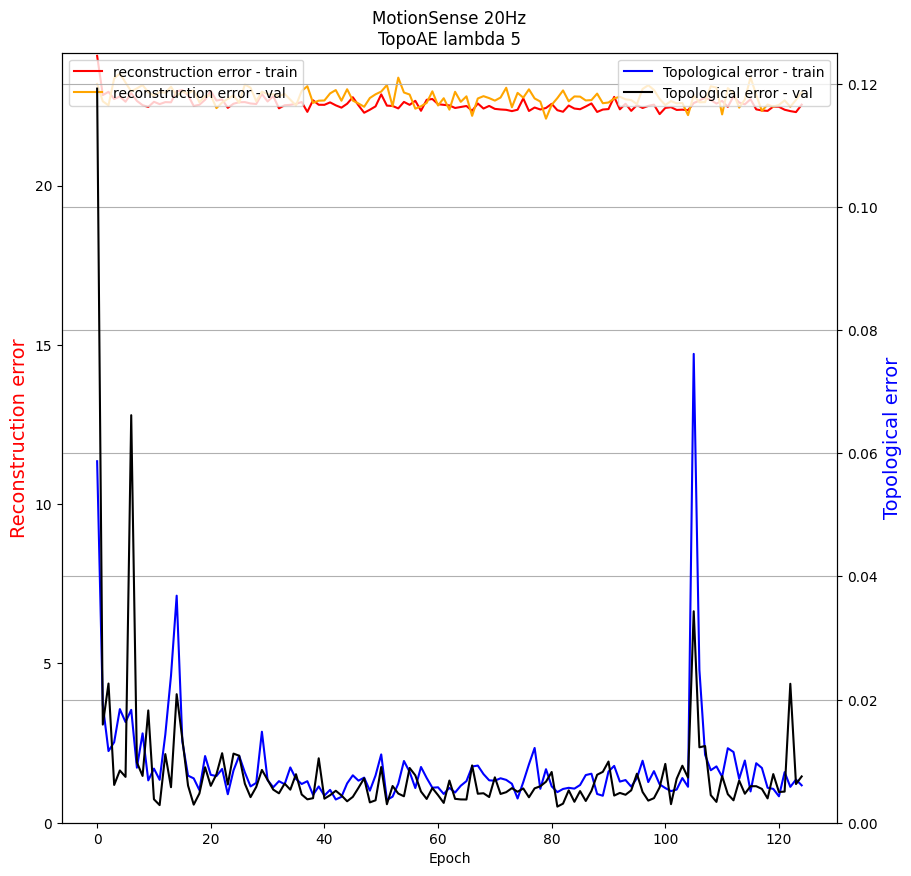

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 2
Epoch:1, P:None, Loss:23.6004, Loss-ae:23.4569, Loss-topo:0.0287
Epoch:2, P:None, Loss:23.1701, Loss-ae:23.1365, Loss-topo:0.0067
Epoch:3, P:None, Loss:23.0982, Loss-ae:23.0577, Loss-topo:0.0081
Epoch:4, P:None, Loss:23.1494, Loss-ae:23.0920, Loss-topo:0.0115
Epoch:5, P:None, Loss:23.3193, Loss-ae:23.2772, Loss-topo:0.0084
Epoch:6, P:None, Loss:22.3839, Loss-ae:22.3587, Loss-topo:0.0050
Epoch:7, P:None, Loss:22.9531, Loss-ae:22.9283, Loss-topo:0.0050
Epoch:8, P:None, Loss:23.1722, Loss-ae:23.1358, Loss-topo:0.0073
Epoch:9, P:None, Loss:23.0295, Loss-ae:22.9844, Loss-topo:0.0090
Epoch:10, P:None, Loss:23.2490, Loss-ae:23.2233, Loss-topo:0.0051
Epoch:11, P:None, Loss:22.9908, Loss-ae:22.9707, Loss-topo:0.0040
Epoch:12, P:None, Loss:22.3983, Loss-ae:22.3754, Loss-topo:0.0046
Epoch:13, P:None, Loss:23.2143, Loss-ae:23.1932, Loss-topo:0.0042
Epoch:14, P:None, Loss:2

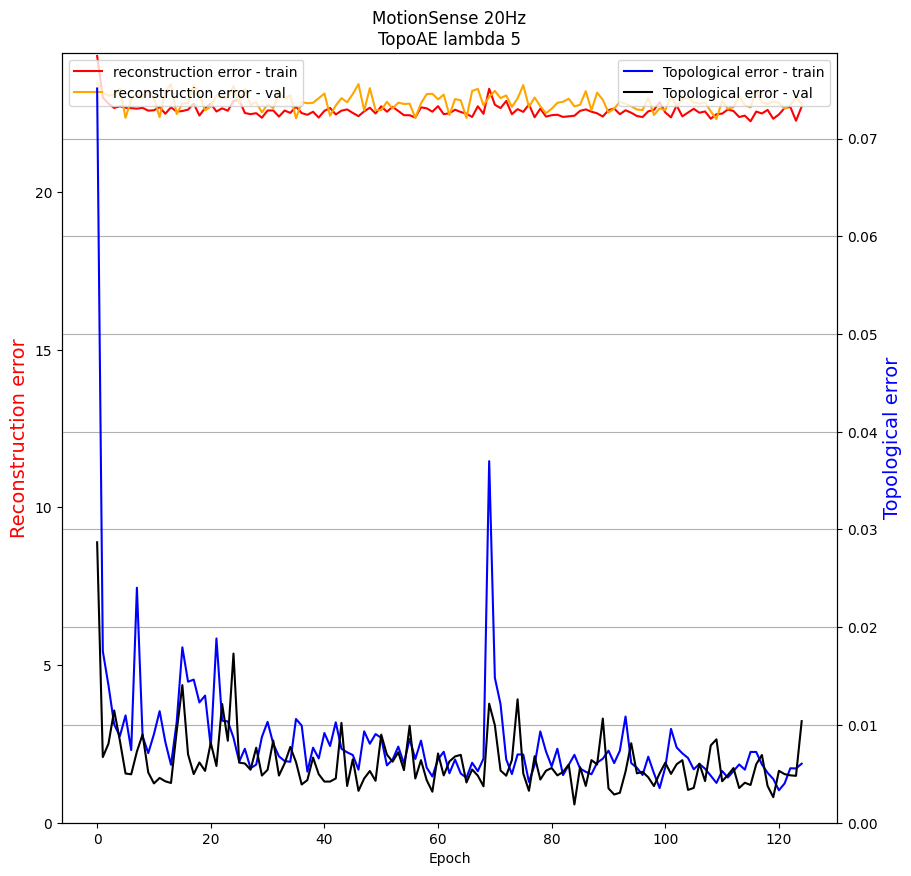

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 2
Epoch:1, P:None, Loss:23.4986, Loss-ae:23.3733, Loss-topo:0.0251
Epoch:2, P:None, Loss:23.4759, Loss-ae:23.4078, Loss-topo:0.0136
Epoch:3, P:None, Loss:23.4585, Loss-ae:23.3875, Loss-topo:0.0142
Epoch:4, P:None, Loss:23.1443, Loss-ae:23.1126, Loss-topo:0.0063
Epoch:5, P:None, Loss:22.6357, Loss-ae:22.6029, Loss-topo:0.0066
Epoch:6, P:None, Loss:22.9277, Loss-ae:22.7650, Loss-topo:0.0325
Epoch:7, P:None, Loss:22.9655, Loss-ae:22.7548, Loss-topo:0.0421
Epoch:8, P:None, Loss:23.0659, Loss-ae:23.0241, Loss-topo:0.0084
Epoch:9, P:None, Loss:22.6927, Loss-ae:22.6484, Loss-topo:0.0089
Epoch:10, P:None, Loss:22.9770, Loss-ae:22.9521, Loss-topo:0.0050
Epoch:11, P:None, Loss:23.1230, Loss-ae:23.0938, Loss-topo:0.0058
Epoch:12, P:None, Loss:22.8114, Loss-ae:22.7767, Loss-topo:0.0069
Epoch:13, P:None, Loss:23.1499, Loss-ae:23.1053, Loss-topo:0.0089
Epoch:14, P:None, Loss:2

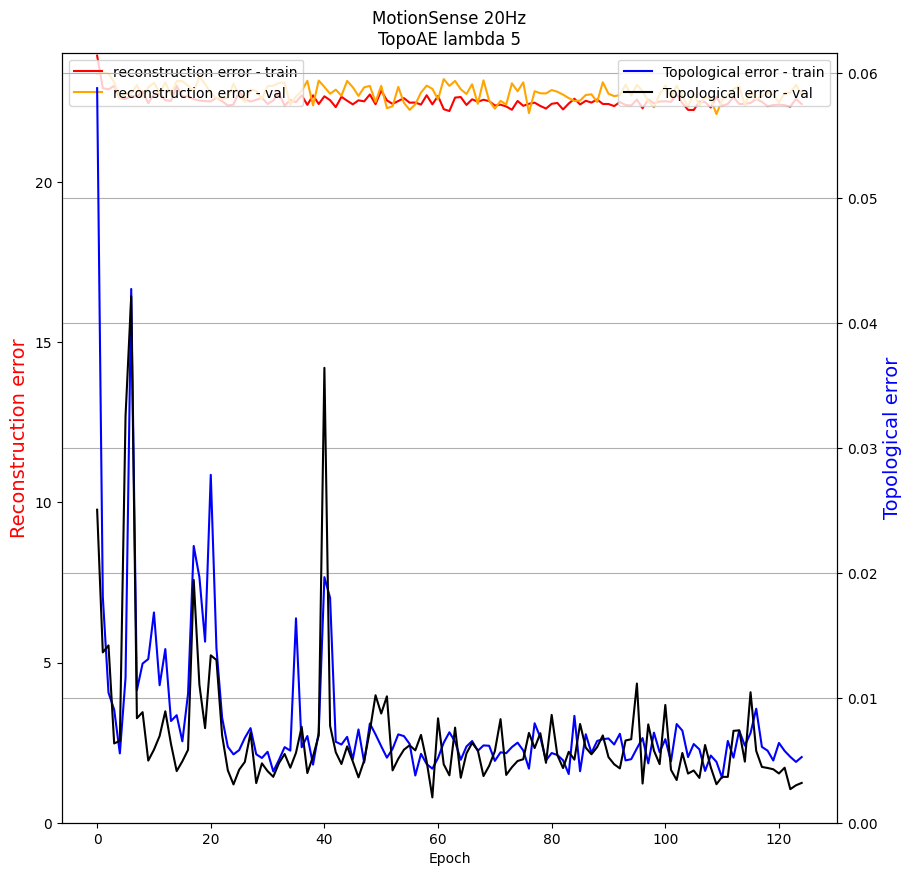

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 2
Epoch:1, P:None, Loss:23.3723, Loss-ae:23.2707, Loss-topo:0.0203
Epoch:2, P:None, Loss:23.1911, Loss-ae:23.1257, Loss-topo:0.0131
Epoch:3, P:None, Loss:23.2283, Loss-ae:23.1643, Loss-topo:0.0128
Epoch:4, P:None, Loss:23.4119, Loss-ae:23.3612, Loss-topo:0.0101
Epoch:5, P:None, Loss:22.9837, Loss-ae:22.9498, Loss-topo:0.0068
Epoch:6, P:None, Loss:23.2582, Loss-ae:23.1240, Loss-topo:0.0268
Epoch:7, P:None, Loss:22.7303, Loss-ae:22.6827, Loss-topo:0.0095
Epoch:8, P:None, Loss:22.8564, Loss-ae:22.8280, Loss-topo:0.0057
Epoch:9, P:None, Loss:23.1560, Loss-ae:22.9551, Loss-topo:0.0402
Epoch:10, P:None, Loss:22.9949, Loss-ae:22.8017, Loss-topo:0.0386
Epoch:11, P:None, Loss:22.9283, Loss-ae:22.9059, Loss-topo:0.0045
Epoch:12, P:None, Loss:22.8471, Loss-ae:22.6771, Loss-topo:0.0340
Epoch:13, P:None, Loss:23.3095, Loss-ae:23.2665, Loss-topo:0.0086
Epoch:14, P:None, Loss:2

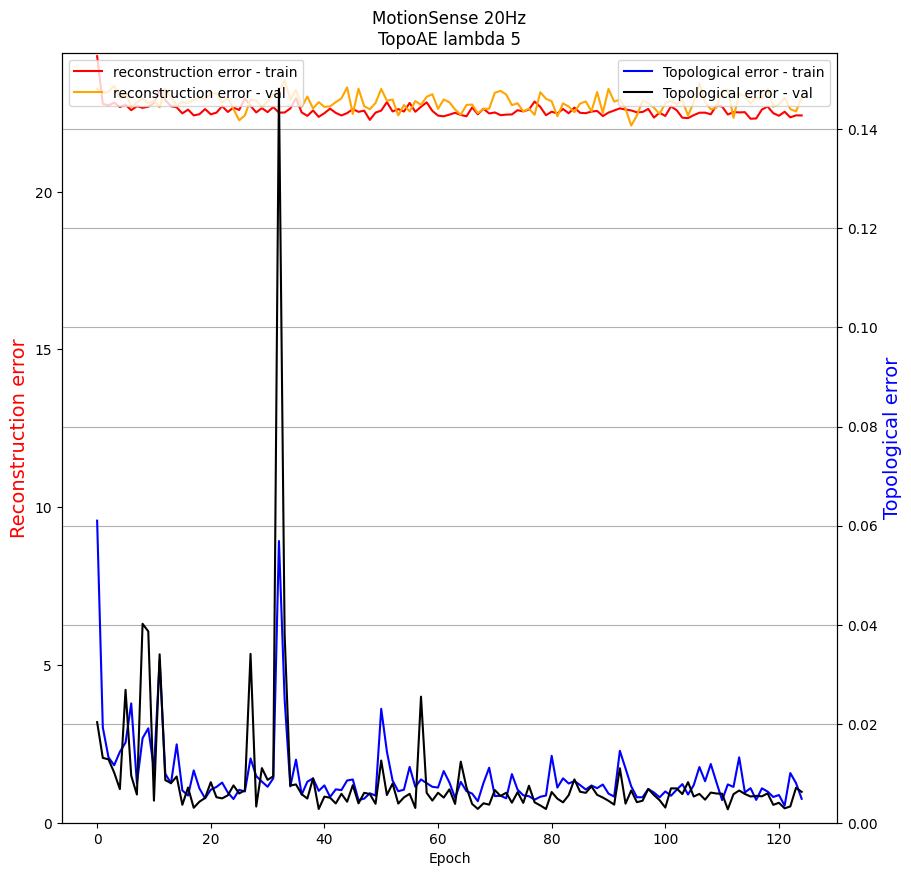

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 2
Epoch:1, P:None, Loss:23.3824, Loss-ae:23.3094, Loss-topo:0.0146
Epoch:2, P:None, Loss:22.9908, Loss-ae:22.9015, Loss-topo:0.0179
Epoch:3, P:None, Loss:22.9201, Loss-ae:22.8974, Loss-topo:0.0045
Epoch:4, P:None, Loss:22.8439, Loss-ae:22.7754, Loss-topo:0.0137
Epoch:5, P:None, Loss:22.6485, Loss-ae:22.6130, Loss-topo:0.0071
Epoch:6, P:None, Loss:22.9658, Loss-ae:22.9281, Loss-topo:0.0076
Epoch:7, P:None, Loss:22.7050, Loss-ae:22.6602, Loss-topo:0.0090
Epoch:8, P:None, Loss:23.0838, Loss-ae:23.0613, Loss-topo:0.0045
Epoch:9, P:None, Loss:23.3849, Loss-ae:23.3605, Loss-topo:0.0049
Epoch:10, P:None, Loss:22.9816, Loss-ae:22.9607, Loss-topo:0.0042
Epoch:11, P:None, Loss:22.5813, Loss-ae:22.5656, Loss-topo:0.0031
Epoch:12, P:None, Loss:23.5643, Loss-ae:23.5388, Loss-topo:0.0051
Epoch:13, P:None, Loss:23.3809, Loss-ae:23.3413, Loss-topo:0.0079
Epoch:14, P:None, Loss:2

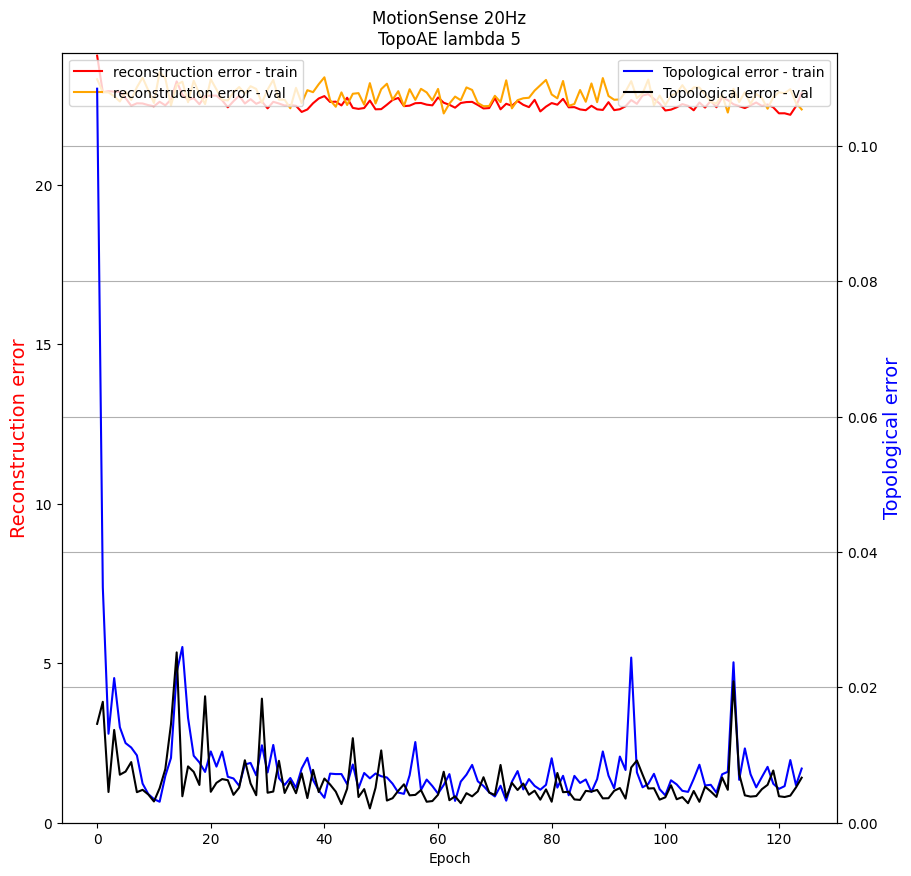

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 2
Epoch:1, P:None, Loss:23.5075, Loss-ae:23.4074, Loss-topo:0.0200
Epoch:2, P:None, Loss:23.2888, Loss-ae:23.2590, Loss-topo:0.0060
Epoch:3, P:None, Loss:22.8545, Loss-ae:22.8243, Loss-topo:0.0060
Epoch:4, P:None, Loss:23.0760, Loss-ae:23.0206, Loss-topo:0.0111
Epoch:5, P:None, Loss:22.7299, Loss-ae:22.6931, Loss-topo:0.0073
Epoch:6, P:None, Loss:23.6248, Loss-ae:23.5416, Loss-topo:0.0166
Epoch:7, P:None, Loss:23.3238, Loss-ae:23.2805, Loss-topo:0.0087
Epoch:8, P:None, Loss:22.8714, Loss-ae:22.8164, Loss-topo:0.0110
Epoch:9, P:None, Loss:23.1861, Loss-ae:23.1323, Loss-topo:0.0108
Epoch:10, P:None, Loss:23.0353, Loss-ae:22.9222, Loss-topo:0.0226
Epoch:11, P:None, Loss:22.8353, Loss-ae:22.8102, Loss-topo:0.0050
Epoch:12, P:None, Loss:23.1073, Loss-ae:23.0925, Loss-topo:0.0030
Epoch:13, P:None, Loss:22.9570, Loss-ae:22.9196, Loss-topo:0.0075
Epoch:14, P:None, Loss:2

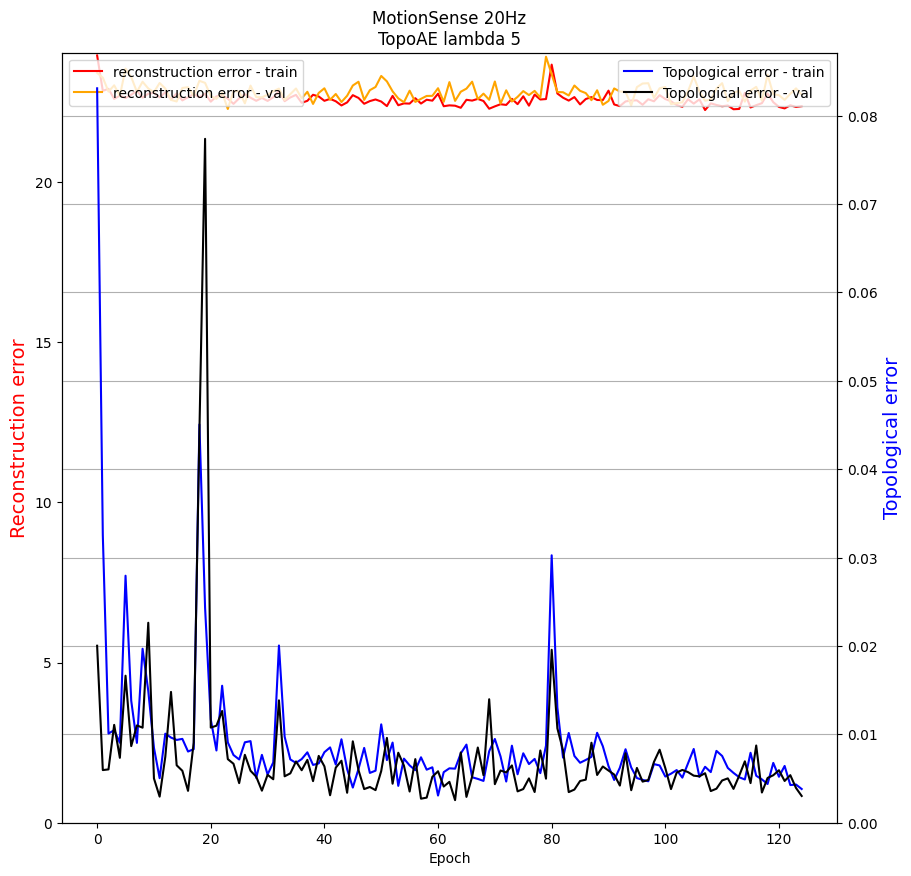

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 2
Epoch:1, P:None, Loss:23.0410, Loss-ae:22.8677, Loss-topo:0.0347
Epoch:2, P:None, Loss:23.0744, Loss-ae:23.0065, Loss-topo:0.0136
Epoch:3, P:None, Loss:23.3072, Loss-ae:23.2612, Loss-topo:0.0092
Epoch:4, P:None, Loss:23.0932, Loss-ae:23.0608, Loss-topo:0.0065
Epoch:5, P:None, Loss:22.9598, Loss-ae:22.8243, Loss-topo:0.0271
Epoch:6, P:None, Loss:22.9555, Loss-ae:22.9148, Loss-topo:0.0081
Epoch:7, P:None, Loss:23.0237, Loss-ae:22.9126, Loss-topo:0.0222
Epoch:8, P:None, Loss:22.7243, Loss-ae:22.6758, Loss-topo:0.0097
Epoch:9, P:None, Loss:22.9918, Loss-ae:22.9496, Loss-topo:0.0084
Epoch:10, P:None, Loss:22.9212, Loss-ae:22.8977, Loss-topo:0.0047
Epoch:11, P:None, Loss:22.8963, Loss-ae:22.7988, Loss-topo:0.0195
Epoch:12, P:None, Loss:23.2034, Loss-ae:23.1489, Loss-topo:0.0109
Epoch:13, P:None, Loss:22.7441, Loss-ae:22.7015, Loss-topo:0.0085
Epoch:14, P:None, Loss:2

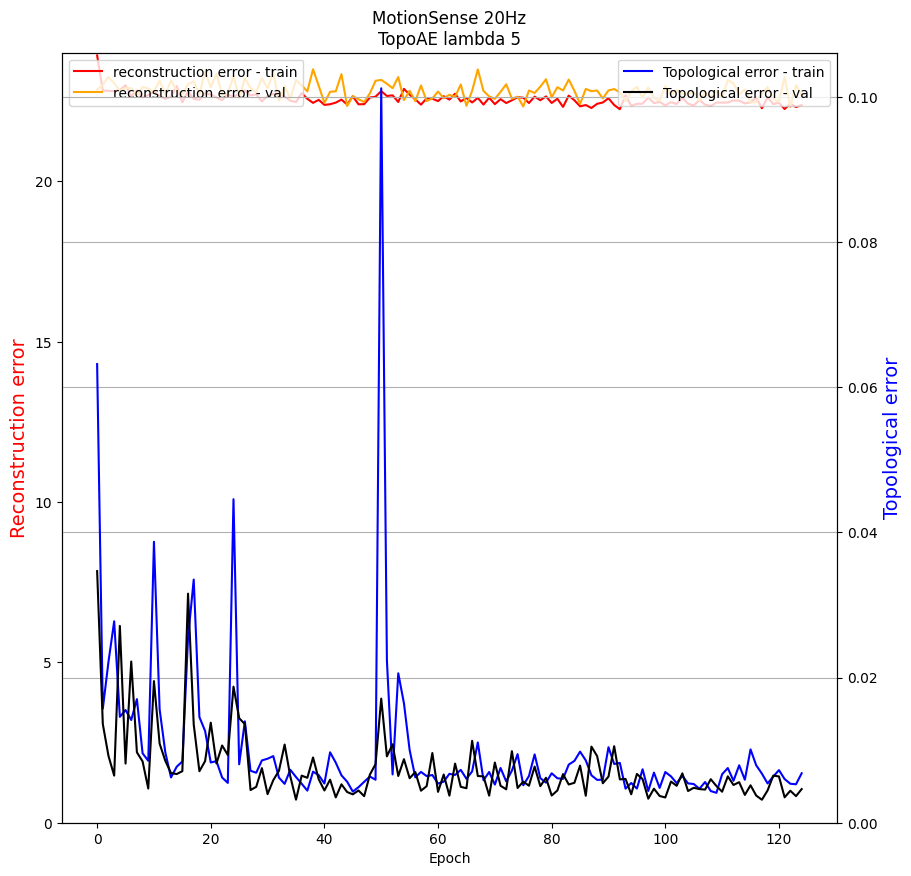

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 3
Epoch:1, P:None, Loss:23.3486, Loss-ae:23.2530, Loss-topo:0.0191
Epoch:2, P:None, Loss:23.2805, Loss-ae:23.2378, Loss-topo:0.0085
Epoch:3, P:None, Loss:22.8322, Loss-ae:22.7878, Loss-topo:0.0089
Epoch:4, P:None, Loss:23.2562, Loss-ae:23.2168, Loss-topo:0.0079
Epoch:5, P:None, Loss:22.8728, Loss-ae:22.7979, Loss-topo:0.0150
Epoch:6, P:None, Loss:22.5434, Loss-ae:22.4979, Loss-topo:0.0091
Epoch:7, P:None, Loss:22.8736, Loss-ae:22.8431, Loss-topo:0.0061
Epoch:8, P:None, Loss:22.7793, Loss-ae:22.7512, Loss-topo:0.0056
Epoch:9, P:None, Loss:22.8457, Loss-ae:22.8128, Loss-topo:0.0066
Epoch:10, P:None, Loss:22.8885, Loss-ae:22.8682, Loss-topo:0.0040
Epoch:11, P:None, Loss:23.0008, Loss-ae:22.9171, Loss-topo:0.0167
Epoch:12, P:None, Loss:22.9689, Loss-ae:22.9436, Loss-topo:0.0051
Epoch:13, P:None, Loss:22.8394, Loss-ae:22.8040, Loss-topo:0.0071
Epoch:14, P:None, Loss:2

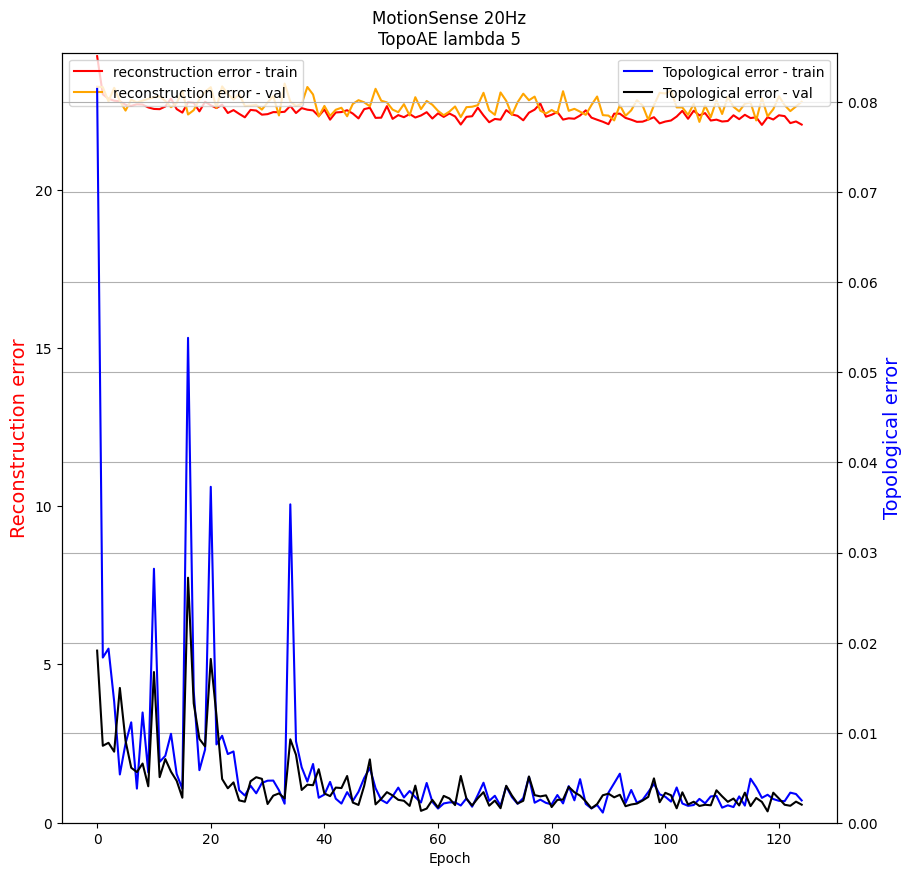

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 3
Epoch:1, P:None, Loss:23.3017, Loss-ae:23.2191, Loss-topo:0.0165
Epoch:2, P:None, Loss:22.8878, Loss-ae:22.8644, Loss-topo:0.0047
Epoch:3, P:None, Loss:23.0898, Loss-ae:23.0540, Loss-topo:0.0072
Epoch:4, P:None, Loss:22.4943, Loss-ae:22.4639, Loss-topo:0.0061
Epoch:5, P:None, Loss:23.1358, Loss-ae:23.1054, Loss-topo:0.0061
Epoch:6, P:None, Loss:22.7223, Loss-ae:22.6845, Loss-topo:0.0076
Epoch:7, P:None, Loss:22.7971, Loss-ae:22.7739, Loss-topo:0.0046
Epoch:8, P:None, Loss:23.0195, Loss-ae:22.9164, Loss-topo:0.0206
Epoch:9, P:None, Loss:22.9442, Loss-ae:22.9078, Loss-topo:0.0073
Epoch:10, P:None, Loss:22.7289, Loss-ae:22.6913, Loss-topo:0.0075
Epoch:11, P:None, Loss:22.8960, Loss-ae:22.5522, Loss-topo:0.0687
Epoch:12, P:None, Loss:23.2610, Loss-ae:23.2414, Loss-topo:0.0039
Epoch:13, P:None, Loss:22.6406, Loss-ae:22.4986, Loss-topo:0.0284
Epoch:14, P:None, Loss:2

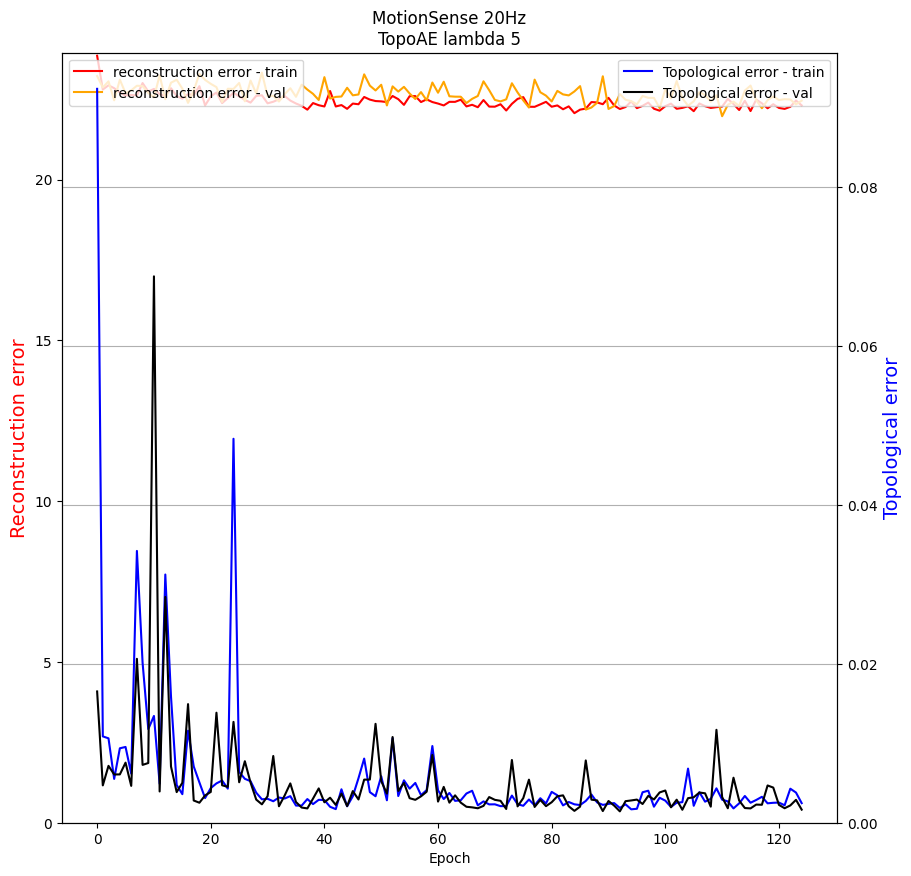

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 3
Epoch:1, P:None, Loss:23.0708, Loss-ae:22.9776, Loss-topo:0.0186
Epoch:2, P:None, Loss:23.6929, Loss-ae:23.4724, Loss-topo:0.0441
Epoch:3, P:None, Loss:23.0741, Loss-ae:23.0315, Loss-topo:0.0085
Epoch:4, P:None, Loss:22.7585, Loss-ae:22.7244, Loss-topo:0.0068
Epoch:5, P:None, Loss:22.8105, Loss-ae:22.7775, Loss-topo:0.0066
Epoch:6, P:None, Loss:23.0190, Loss-ae:22.9854, Loss-topo:0.0067
Epoch:7, P:None, Loss:22.7128, Loss-ae:22.6891, Loss-topo:0.0047
Epoch:8, P:None, Loss:22.9453, Loss-ae:22.8856, Loss-topo:0.0119
Epoch:9, P:None, Loss:22.6429, Loss-ae:22.6073, Loss-topo:0.0071
Epoch:10, P:None, Loss:23.0218, Loss-ae:23.0075, Loss-topo:0.0029
Epoch:11, P:None, Loss:22.6307, Loss-ae:22.6116, Loss-topo:0.0038
Epoch:12, P:None, Loss:22.9879, Loss-ae:22.9648, Loss-topo:0.0046
Epoch:13, P:None, Loss:23.1785, Loss-ae:23.1147, Loss-topo:0.0128
Epoch:14, P:None, Loss:2

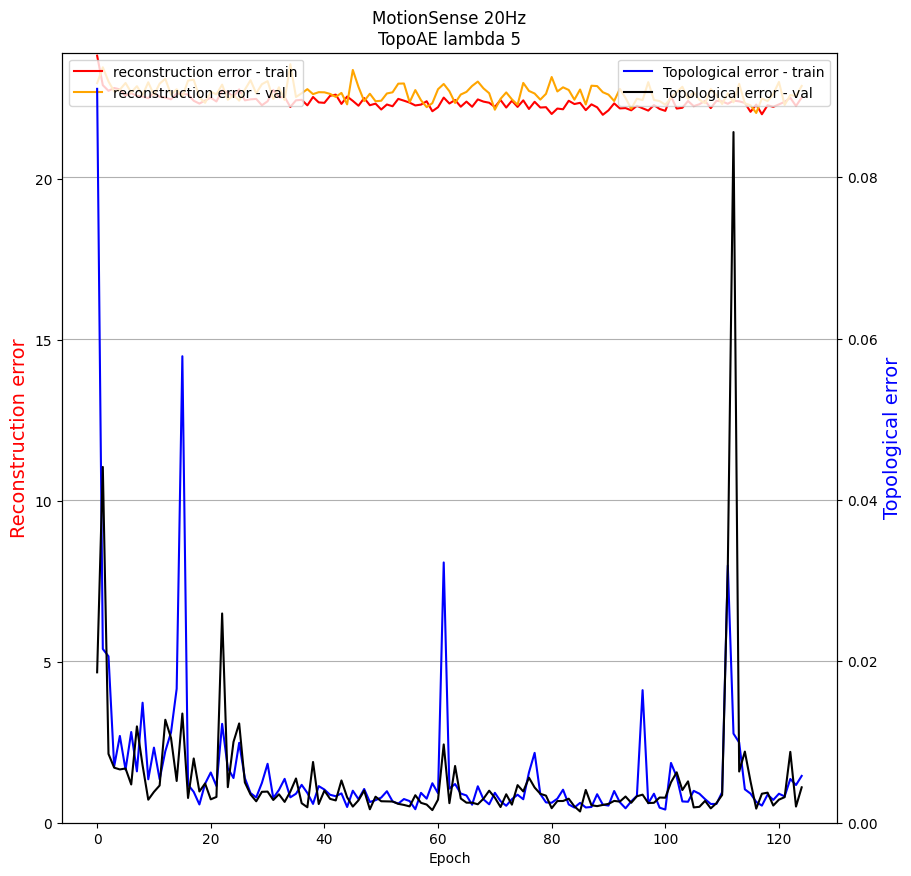

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 3
Epoch:1, P:None, Loss:23.3507, Loss-ae:23.2946, Loss-topo:0.0112
Epoch:2, P:None, Loss:23.0431, Loss-ae:22.9940, Loss-topo:0.0098
Epoch:3, P:None, Loss:23.2402, Loss-ae:23.0435, Loss-topo:0.0393
Epoch:4, P:None, Loss:23.1040, Loss-ae:23.0367, Loss-topo:0.0135
Epoch:5, P:None, Loss:22.6078, Loss-ae:22.5827, Loss-topo:0.0050
Epoch:6, P:None, Loss:23.2349, Loss-ae:23.0346, Loss-topo:0.0401
Epoch:7, P:None, Loss:22.9322, Loss-ae:22.8882, Loss-topo:0.0088
Epoch:8, P:None, Loss:23.0075, Loss-ae:22.9831, Loss-topo:0.0049
Epoch:9, P:None, Loss:22.3645, Loss-ae:22.3427, Loss-topo:0.0044
Epoch:10, P:None, Loss:22.7917, Loss-ae:22.7791, Loss-topo:0.0025
Epoch:11, P:None, Loss:22.8619, Loss-ae:22.8488, Loss-topo:0.0026
Epoch:12, P:None, Loss:22.5997, Loss-ae:22.5608, Loss-topo:0.0078
Epoch:13, P:None, Loss:23.2752, Loss-ae:23.2485, Loss-topo:0.0053
Epoch:14, P:None, Loss:2

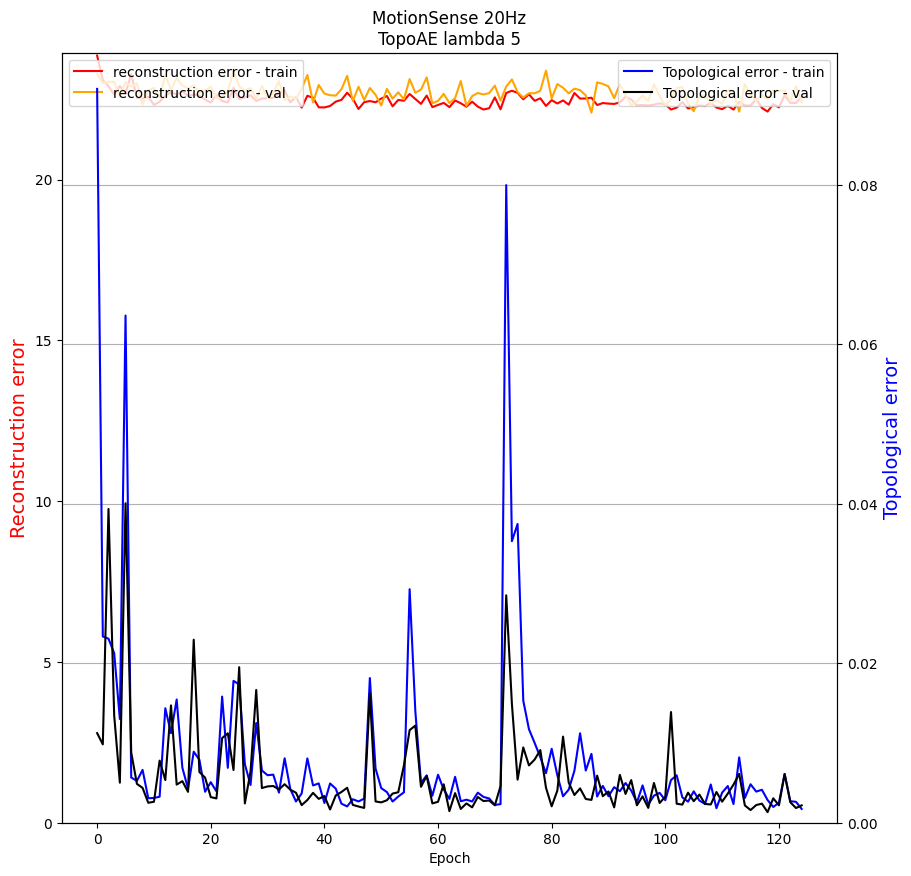

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 3
Epoch:1, P:None, Loss:23.2831, Loss-ae:23.2316, Loss-topo:0.0103
Epoch:2, P:None, Loss:22.8502, Loss-ae:22.7955, Loss-topo:0.0109
Epoch:3, P:None, Loss:23.0840, Loss-ae:23.0421, Loss-topo:0.0084
Epoch:4, P:None, Loss:23.5255, Loss-ae:23.4445, Loss-topo:0.0162
Epoch:5, P:None, Loss:22.7005, Loss-ae:22.6640, Loss-topo:0.0073
Epoch:6, P:None, Loss:22.9028, Loss-ae:22.8487, Loss-topo:0.0108
Epoch:7, P:None, Loss:22.7487, Loss-ae:22.6665, Loss-topo:0.0164
Epoch:8, P:None, Loss:22.9004, Loss-ae:22.8772, Loss-topo:0.0046
Epoch:9, P:None, Loss:22.9564, Loss-ae:22.9239, Loss-topo:0.0065
Epoch:10, P:None, Loss:22.8718, Loss-ae:22.8461, Loss-topo:0.0051
Epoch:11, P:None, Loss:23.0102, Loss-ae:22.9899, Loss-topo:0.0041
Epoch:12, P:None, Loss:23.5338, Loss-ae:23.5216, Loss-topo:0.0024
Epoch:13, P:None, Loss:22.9743, Loss-ae:22.8714, Loss-topo:0.0206
Epoch:14, P:None, Loss:2

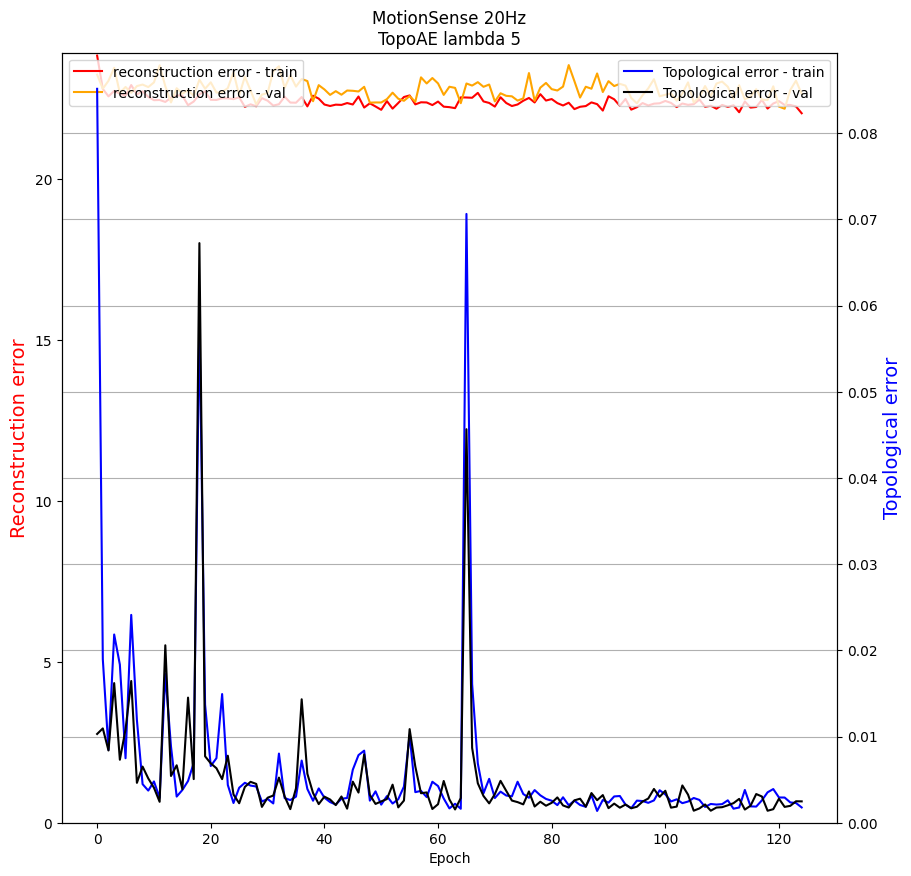

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 3
Epoch:1, P:None, Loss:23.8882, Loss-ae:23.6124, Loss-topo:0.0551
Epoch:2, P:None, Loss:22.8463, Loss-ae:22.8111, Loss-topo:0.0070
Epoch:3, P:None, Loss:22.9553, Loss-ae:22.9270, Loss-topo:0.0057
Epoch:4, P:None, Loss:22.9329, Loss-ae:22.8457, Loss-topo:0.0174
Epoch:5, P:None, Loss:22.5860, Loss-ae:22.5292, Loss-topo:0.0114
Epoch:6, P:None, Loss:22.9099, Loss-ae:22.8740, Loss-topo:0.0072
Epoch:7, P:None, Loss:22.8853, Loss-ae:22.8510, Loss-topo:0.0069
Epoch:8, P:None, Loss:22.8140, Loss-ae:22.7943, Loss-topo:0.0039
Epoch:9, P:None, Loss:22.9844, Loss-ae:22.8441, Loss-topo:0.0281
Epoch:10, P:None, Loss:23.2931, Loss-ae:23.0424, Loss-topo:0.0501
Epoch:11, P:None, Loss:23.1496, Loss-ae:23.0328, Loss-topo:0.0234
Epoch:12, P:None, Loss:23.2325, Loss-ae:23.2059, Loss-topo:0.0053
Epoch:13, P:None, Loss:22.9983, Loss-ae:22.9647, Loss-topo:0.0067
Epoch:14, P:None, Loss:2

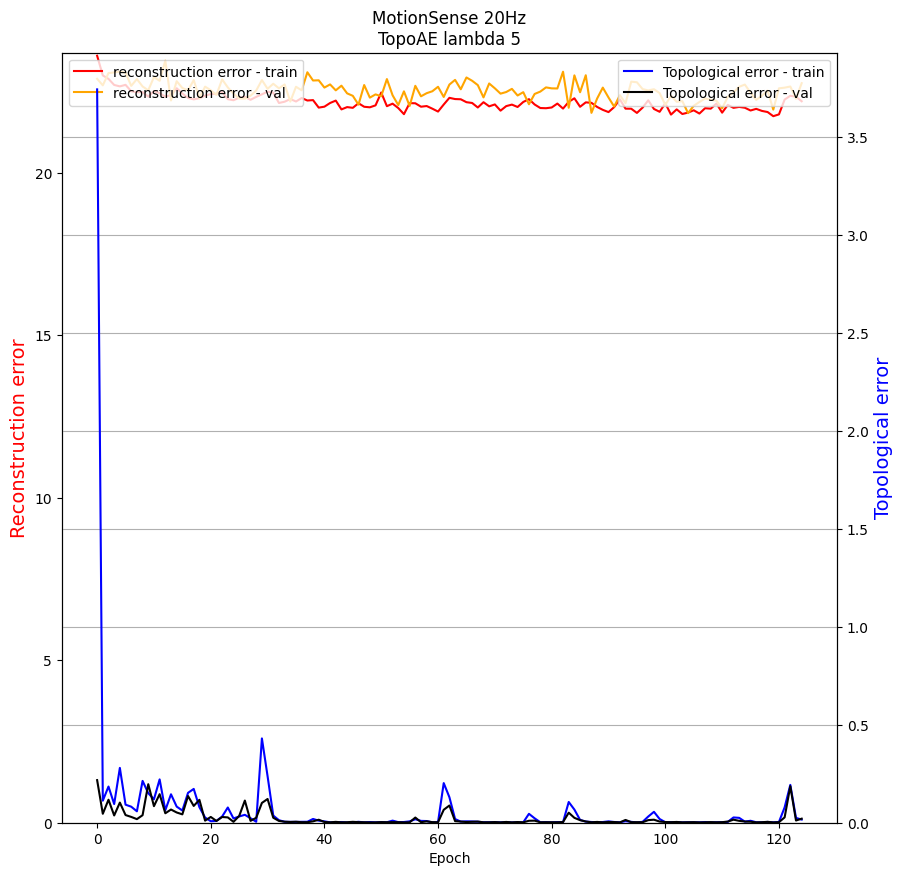

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 100
Epoch:1, P:None, Loss:23.9882, Loss-ae:23.2357, Loss-topo:0.1505
Epoch:2, P:None, Loss:23.4309, Loss-ae:23.1464, Loss-topo:0.0569
Epoch:3, P:None, Loss:23.3794, Loss-ae:22.6713, Loss-topo:0.1416
Epoch:4, P:None, Loss:22.4527, Loss-ae:22.3351, Loss-topo:0.0235
Epoch:5, P:None, Loss:22.4653, Loss-ae:22.3602, Loss-topo:0.0210
Epoch:6, P:None, Loss:23.3734, Loss-ae:23.2264, Loss-topo:0.0294
Epoch:7, P:None, Loss:23.1568, Loss-ae:22.4032, Loss-topo:0.1507
Epoch:8, P:None, Loss:25.7713, Loss-ae:23.1022, Loss-topo:0.5338
Epoch:9, P:None, Loss:23.1212, Loss-ae:22.5771, Loss-topo:0.1088
Epoch:10, P:None, Loss:24.2762, Loss-ae:22.8949, Loss-topo:0.2763
Epoch:11, P:None, Loss:23.6438, Loss-ae:23.1193, Loss-topo:0.1049
Epoch:12, P:None, Loss:22.5983, Loss-ae:22.5415, Loss-topo:0.0114
Epoch:13, P:None, Loss:22.8012, Loss-ae:22.6830, Loss-topo:0.0236
Epoch:14, P:None, Loss

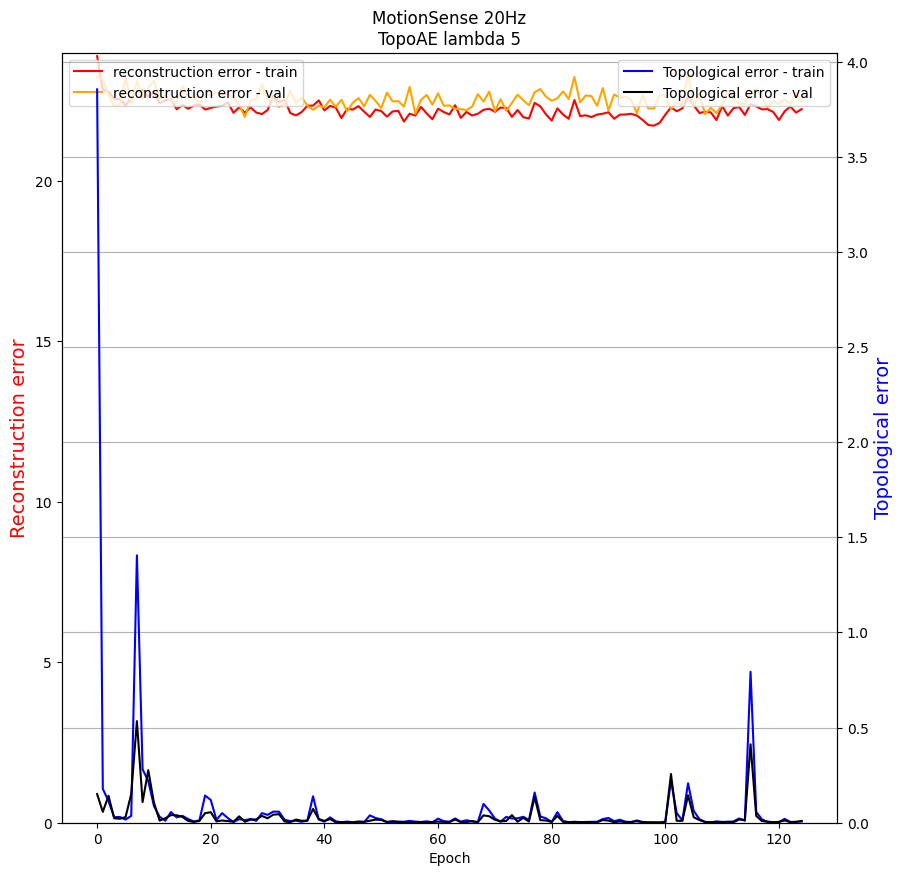

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 100
Epoch:1, P:None, Loss:24.0639, Loss-ae:22.7619, Loss-topo:0.2604
Epoch:2, P:None, Loss:23.0646, Loss-ae:22.8276, Loss-topo:0.0474
Epoch:3, P:None, Loss:23.6661, Loss-ae:23.3156, Loss-topo:0.0701
Epoch:4, P:None, Loss:23.0638, Loss-ae:22.9133, Loss-topo:0.0301
Epoch:5, P:None, Loss:22.6607, Loss-ae:22.5297, Loss-topo:0.0262
Epoch:6, P:None, Loss:23.5745, Loss-ae:22.9578, Loss-topo:0.1233
Epoch:7, P:None, Loss:23.1290, Loss-ae:22.9300, Loss-topo:0.0398
Epoch:8, P:None, Loss:23.1110, Loss-ae:22.9790, Loss-topo:0.0264
Epoch:9, P:None, Loss:23.1276, Loss-ae:22.9299, Loss-topo:0.0395
Epoch:10, P:None, Loss:23.0635, Loss-ae:22.8209, Loss-topo:0.0485
Epoch:11, P:None, Loss:24.0700, Loss-ae:23.3621, Loss-topo:0.1416
Epoch:12, P:None, Loss:22.5786, Loss-ae:22.4247, Loss-topo:0.0308
Epoch:13, P:None, Loss:22.8546, Loss-ae:22.5247, Loss-topo:0.0660
Epoch:14, P:None, Loss

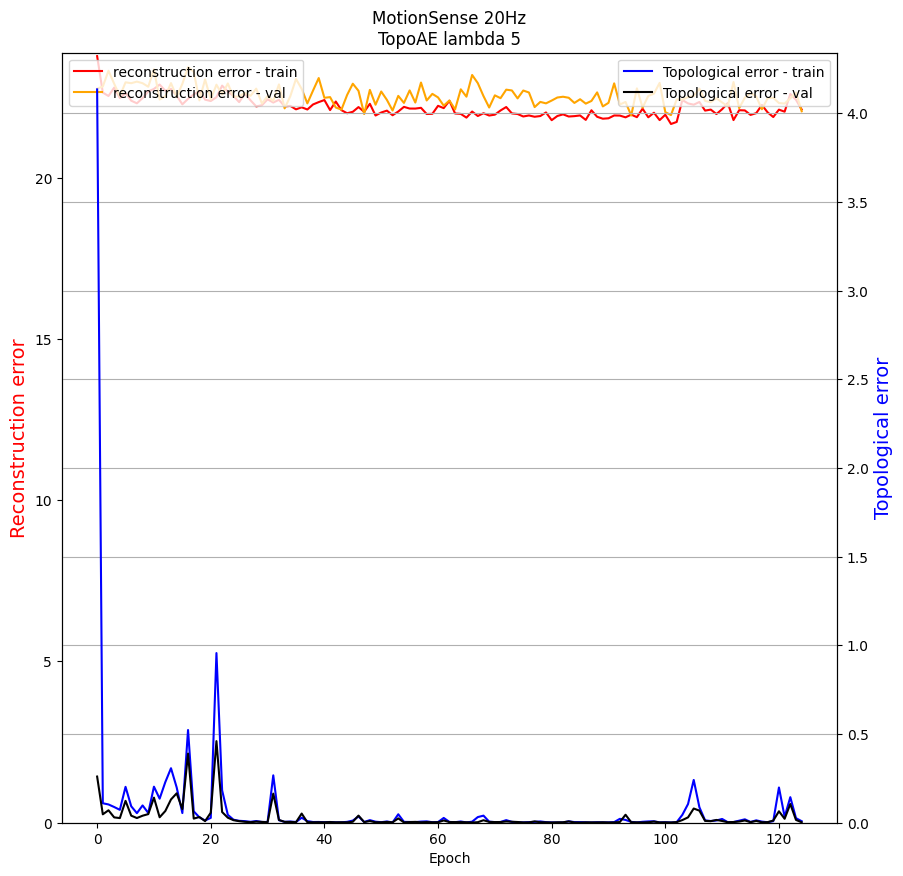

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 100
Epoch:1, P:None, Loss:24.0654, Loss-ae:22.9635, Loss-topo:0.2204
Epoch:2, P:None, Loss:23.2072, Loss-ae:22.9113, Loss-topo:0.0592
Epoch:3, P:None, Loss:24.5592, Loss-ae:23.3954, Loss-topo:0.2328
Epoch:4, P:None, Loss:23.6767, Loss-ae:23.0422, Loss-topo:0.1269
Epoch:5, P:None, Loss:23.0965, Loss-ae:22.9054, Loss-topo:0.0382
Epoch:6, P:None, Loss:23.1494, Loss-ae:22.9956, Loss-topo:0.0308
Epoch:7, P:None, Loss:22.7064, Loss-ae:22.5781, Loss-topo:0.0256
Epoch:8, P:None, Loss:25.0170, Loss-ae:22.7768, Loss-topo:0.4480
Epoch:9, P:None, Loss:22.9950, Loss-ae:22.7498, Loss-topo:0.0490
Epoch:10, P:None, Loss:23.9550, Loss-ae:23.7569, Loss-topo:0.0396
Epoch:11, P:None, Loss:22.4576, Loss-ae:22.3347, Loss-topo:0.0246
Epoch:12, P:None, Loss:22.7800, Loss-ae:22.5992, Loss-topo:0.0362
Epoch:13, P:None, Loss:22.7119, Loss-ae:22.5451, Loss-topo:0.0334
Epoch:14, P:None, Loss

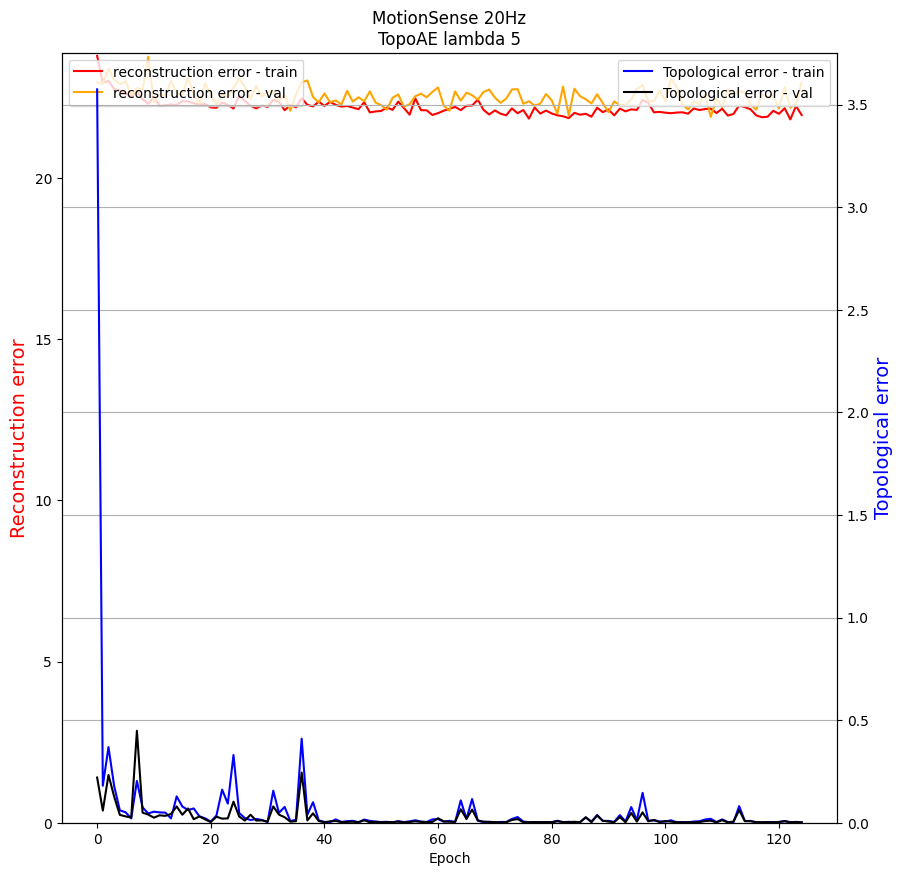

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 100
Epoch:1, P:None, Loss:23.2871, Loss-ae:22.6830, Loss-topo:0.1208
Epoch:2, P:None, Loss:23.6137, Loss-ae:23.0237, Loss-topo:0.1180
Epoch:3, P:None, Loss:23.2443, Loss-ae:23.0050, Loss-topo:0.0479
Epoch:4, P:None, Loss:23.3079, Loss-ae:22.8969, Loss-topo:0.0822
Epoch:5, P:None, Loss:23.1554, Loss-ae:22.9680, Loss-topo:0.0375
Epoch:6, P:None, Loss:23.1106, Loss-ae:23.0463, Loss-topo:0.0129
Epoch:7, P:None, Loss:22.6829, Loss-ae:22.6122, Loss-topo:0.0141
Epoch:8, P:None, Loss:23.1452, Loss-ae:22.7878, Loss-topo:0.0715
Epoch:9, P:None, Loss:23.6886, Loss-ae:22.5717, Loss-topo:0.2234
Epoch:10, P:None, Loss:27.1825, Loss-ae:24.1341, Loss-topo:0.6097
Epoch:11, P:None, Loss:24.8755, Loss-ae:22.8673, Loss-topo:0.4016
Epoch:12, P:None, Loss:23.1745, Loss-ae:22.9700, Loss-topo:0.0409
Epoch:13, P:None, Loss:23.3009, Loss-ae:23.0865, Loss-topo:0.0429
Epoch:14, P:None, Loss

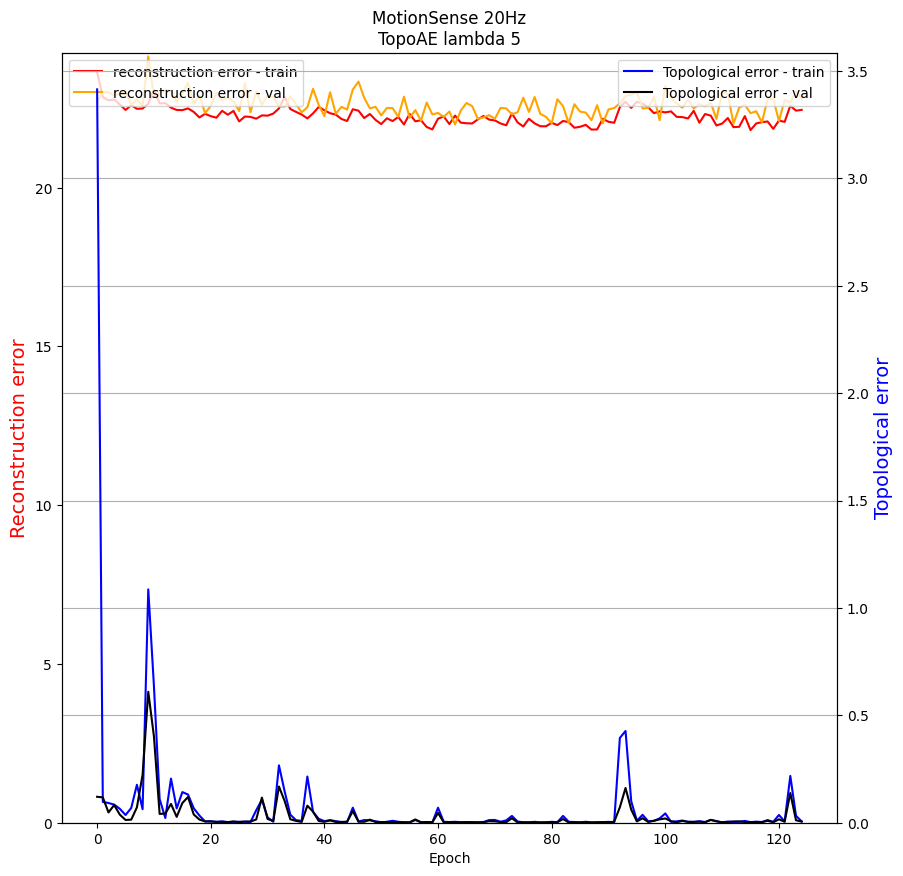

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 360) Inner dim: 100
Epoch:1, P:None, Loss:24.1720, Loss-ae:22.9417, Loss-topo:0.2461
Epoch:2, P:None, Loss:23.7791, Loss-ae:23.2565, Loss-topo:0.1045
Epoch:3, P:None, Loss:23.2411, Loss-ae:22.9907, Loss-topo:0.0501
Epoch:4, P:None, Loss:24.7669, Loss-ae:23.2579, Loss-topo:0.3018
Epoch:5, P:None, Loss:23.0984, Loss-ae:22.7851, Loss-topo:0.0627
Epoch:6, P:None, Loss:22.7932, Loss-ae:22.6573, Loss-topo:0.0272
Epoch:7, P:None, Loss:23.2344, Loss-ae:23.1114, Loss-topo:0.0246
Epoch:8, P:None, Loss:23.4687, Loss-ae:23.1115, Loss-topo:0.0714
Epoch:9, P:None, Loss:23.6744, Loss-ae:22.9958, Loss-topo:0.1357
Epoch:10, P:None, Loss:23.5702, Loss-ae:22.7437, Loss-topo:0.1653
Epoch:11, P:None, Loss:24.3980, Loss-ae:23.1440, Loss-topo:0.2508
Epoch:12, P:None, Loss:23.3161, Loss-ae:22.9890, Loss-topo:0.0654
Epoch:13, P:None, Loss:23.1418, Loss-ae:22.9968, Loss-topo:0.0290
Epoch:14, P:None, Loss

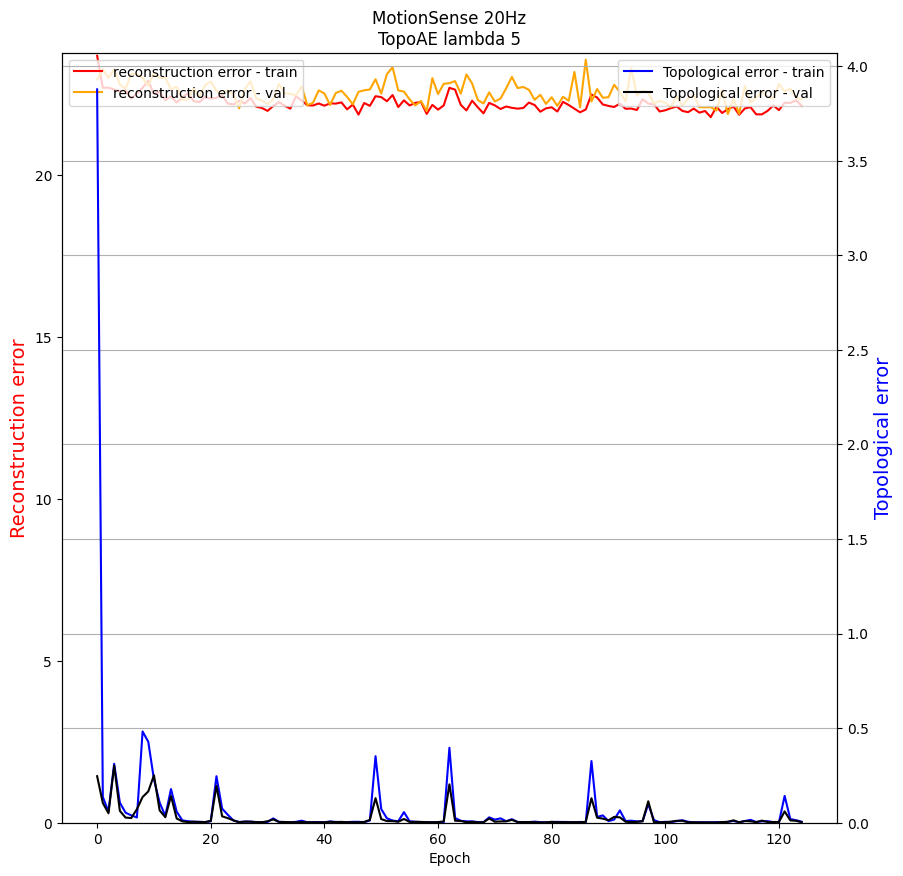

In [16]:
plot_object = {
    'RF-ACC': [],
    'RF-F1': [],
    'SVC-ACC': [],
    'SVC-F1': [],
    'KNN-ACC': [],
    'KNN-F1': [],
    'Trustworthiness': [],
    'Continuity': [],
    'Co-k-NNs': []   
}

for dimension in dimensions_to_explore:
    dimension_exploration = explore_dimension(
        train_HD, train_Y,
        test_HD, test_Y,
        dimension,
        times_to_execute=executions_per_model
    )
    # print(lambda_val, lambda_exploration)
    for obj_property in plot_object:
        plot_object[obj_property].append(dimension_exploration[obj_property])
    
# print(plot_object)

In [17]:
print(plot_object)

{'RF-ACC': [[0.3605882352941177, 0.4158823529411764, 0.3772549019607843, 0.386078431372549, 0.4272549019607843, 0.4600980392156863, 0.4464705882352941, 0.4052941176470588, 0.3426470588235294, 0.3735294117647059], [0.517156862745098, 0.5054901960784314, 0.5, 0.42901960784313725, 0.4765686274509804, 0.5092156862745097, 0.548235294117647, 0.5087254901960784, 0.48931372549019614, 0.5162745098039215], [0.5453921568627451, 0.5565686274509803, 0.5674509803921568, 0.5652941176470587, 0.5187254901960784, 0.5324509803921569, 0.4999019607843137, 0.5477450980392157, 0.5335294117647058, 0.5385294117647059], [0.5541176470588235, 0.5576470588235294, 0.4684313725490196, 0.5435294117647058, 0.5418627450980392, 0.5319607843137255, 0.5509803921568628, 0.5713725490196078, 0.6424509803921568, 0.5516666666666666], [0.5527450980392157, 0.644313725490196, 0.6211764705882354, 0.612156862745098, 0.662843137254902, 0.6249019607843138, 0.6494117647058824, 0.5583333333333333, 0.6459803921568629, 0.5625490196078431